# Plasticity
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/planar/plasticity.ipynb)

We subject a 3D unit cube meshed with linear hexahedrons to a uniaxial stress state in the x-direction. The displacement is increased in increments and the material yields when the stress reaches a critical value. The material is modeled with a v. Mises yield criterion and a linear isotropic hardening law.


In [1]:
import matplotlib.pyplot as plt
import torch

from torchfem import Solid
from torchfem.materials import IsotropicPlasticity3D
from torchfem.mesh import cube_hexa

torch.set_default_dtype(torch.float64)

## Material model
We employ a von Mises yield criterion with isotropic linear hardening. The plastic hardening function is given by

$$
\sigma_f(q) = \sigma_y + k q
$$

with the yield stress $\sigma_y$, the equivalent plastic strain $q$ and the hardening modulus $k$.

## Incremental loading with radial return mapping algorithm 
We implement a radial return mapping algorithm to solve the plasticity problem. In each increment, we calculate the trial stress 
$$ 
\sigma_{\text{trial}} = \sigma_n + C : \Delta\varepsilon
$$
and check if it exceeds the yield surface by evaluating the flow potential
$$ 
f = ||\sigma_{\text{trial}}'|| - \sqrt{\frac{2}{3}}\sigma_f(q).
$$
Here, $||\sigma_{\text{trial}}'||$ denotes the Frobenius norm of the deviatoric part of the trial stress.

1. If $f \leq 0$, the stress state is elastic. We update the variables as follows: 
$$
\sigma_{n+1} = \sigma_{\text{trial}} \\ q_{n+1} = q_{n}\\ d\sigma d\varepsilon_{n+1} = C.
$$

2. If $f > 0$, the stress state is plastic. We need to calculate the equivalent plastic strain $\Delta \gamma$ that leads to $f=0$ to satisfy the yield condition. This is generally a nonlinear equation and we solve it with Newton's method (in case of linear hardening, this is essentially solved in the first step...). We assume, that the direction of of flow is given by the deviatoric part of the trial stress, i.e. $n = \frac{\sigma_{\text{trial}}'}{||\sigma_{\text{trial}}'||}$.
Then, we update the variables as follows: 

$$
\sigma_{n+1} = \sigma_{\text{trial}} - 2 G \Delta \gamma n \\
\quad q_{n+1} = q_{n} + \sqrt{\frac{2}{3}} \Delta \gamma \\
(d\sigma d\varepsilon)_{ijkl} = C_{ijkl} 
    - \frac{2 G}{1 + \frac{\sigma_f'}{3 \mu}} n_{ij} n_{kl}
    - \frac{4 G^2 \Delta\gamma}{||s||} \left(\frac{1}{2} \left( \delta_{ik}\delta_{jl} + \delta_{il}\delta_{kj} \right)
         - \frac{1}{3} \delta_{ij} \delta_{kl}
        - n_{ij} n_{lk} \right)
$$

In [2]:
E = 1000.0
nu = 0.3
sigma_y = 50.0
k = 100.0


# Hardening function
def sigma_f(q):
    return sigma_y + k * q


# Derivative of the hardening function
def sigma_f_prime(q):
    return k


# Elastic properties
material = IsotropicPlasticity3D(E, nu, sigma_f, sigma_f_prime)

In [3]:
# Generate cube
nodes, elements = cube_hexa(5, 5, 5)

box = Solid(nodes, elements, material)

# Set constraints
DL = 0.1
box.displacements[nodes[:, 0] == 1.0, 0] = DL
box.constraints[nodes[:, 0] == 0.0, 0] = True
box.constraints[nodes[:, 0] == 1.0, 0] = True
box.constraints[nodes[:, 1] == 0.5, 1] = True
box.constraints[nodes[:, 2] == 0.5, 2] = True

# Incremental loading
increments = torch.cat((torch.linspace(0.0, 1.0, 10), torch.linspace(1.0, 0.0, 10)))
u, f, σ, ε, α = box.solve(increments=increments, return_intermediate=True, max_iter=20)

## Postprocessing and evaluation

The reference solution for the plastic region is given by solving the hardening rule
$$
\sigma = \sigma_y + K q
$$
for $q$ and substituting it into the elastic equation
$$
\sigma = E (\varepsilon - q).
$$
Solving for $\sigma$ gives 
$$
\sigma = \frac{kE}{k+E} (\varepsilon + \frac{\sigma_y}{k}).
$$

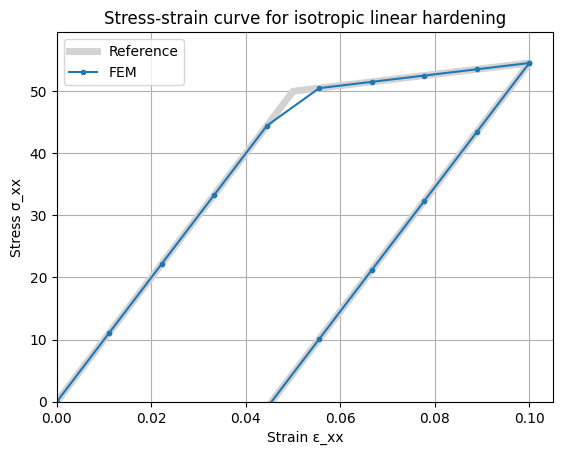

In [4]:
ref_strain = [0.0, sigma_y / E, DL, DL - k / (k + E) * (DL + sigma_y / k)]
ref_stress = [0.0, sigma_y, k * E / (k + E) * (DL + sigma_y / k), 0]

# Average x components over elements
strain = ε[:, :, 0].mean(dim=1)
stress = σ[:, :, 0].mean(dim=1)

plt.plot(ref_strain, ref_stress, "-", color="lightgray", linewidth=5, label="Reference")
plt.plot(strain, stress, ".-", label="FEM")
plt.xlabel("Strain ε_xx")
plt.ylabel("Stress σ_xx")
plt.title("Stress-strain curve for isotropic linear hardening")
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.grid()
plt.legend()
plt.show()